<a href="https://colab.research.google.com/github/AVaultCode/css-exercises/blob/main/Pr%C3%A1ctica_3_Albarracin_Gallo_Jin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pr√°ctica 3: Redes neuronales convolucionales para clasificaci√≥n de im√°genes

En esta pr√°ctica, vamos a utilizar modelos profundos para clasificar d√≠gitos manuscritos, de forma similar al pr√°ctico 0. En este caso, utilizaremos el dataset MNIST donde los d√≠gitos poseen un tama√±o de 28x28 (en lugar de 8x8 como en el pr√°ctico 1).

Para eso, comenzamos por cargar y visualizar el dataset:

Failed to download (trying next):
HTTP Error 404: Not Found



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.54k/4.54k [00:00<00:00, 5.97MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



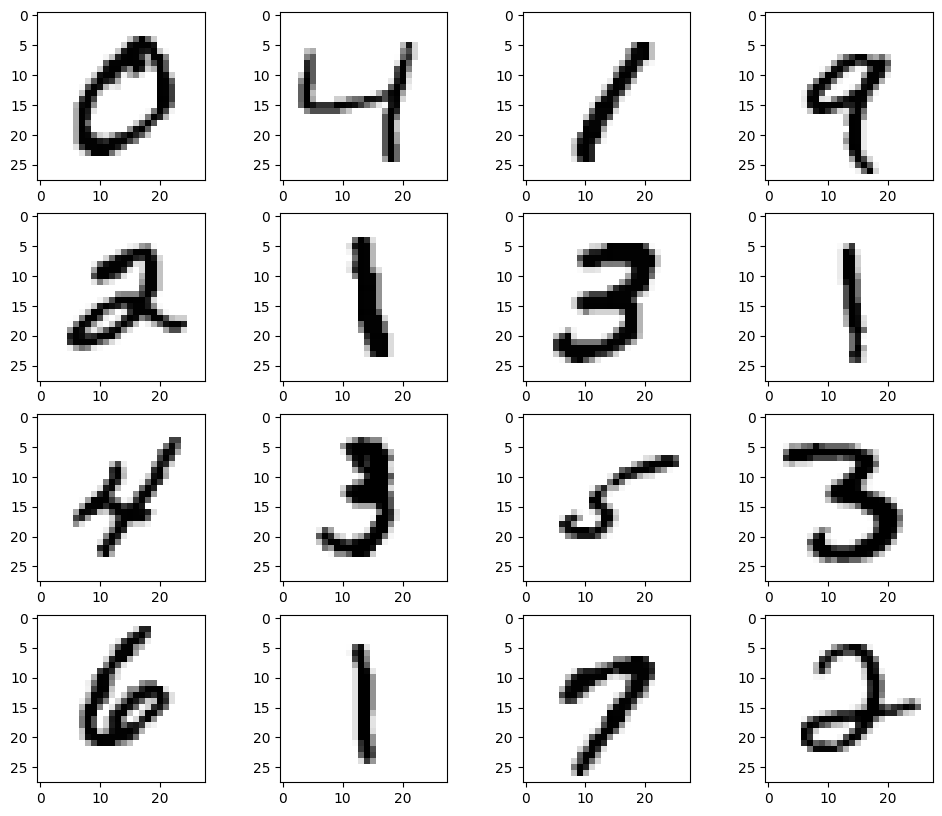

In [ ]:
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))


# Perceptr√≥n multicapa

Primero, vamos a adaptar el perceptr√≥n mutlicapa implementado en la pr√°ctica anterior, para que pueda clasificar im√°genes de 28 x 28 en 10 categor√≠as diferentes. Para ello, deberemos realizar algunos cambios:

* Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28, a un vector de 784 componetes. Para ello, utilziaremos el m√©todo `view` de los tensores de Pytorch.

* Utilizaremos un perceptr√≥n con 15 neuronas en las capas intermedias.

* La √∫ltima capa deber√° tener 10 neuronas (en lugar de 1 sola como tenia el perceptr√≥n multicapa que utilizamos para hacer regresi√≥n).

* Deberemos cambiar la funci√≥n de p√©rdida. En este caso, utilizaremos Entrop√≠a Cruzada (`torch.nn.CrossEntropyLoss`)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class NetMLP(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(NetMLP, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)  # Primera capa oculta
        self.hidden2 = nn.Linear(size_hidden, size_hidden)  # Segunda capa oculta
        self.out = nn.Linear(size_hidden, n_output)  # Capa de salida con 10 neuronas (una por cada clase)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Reformatear de [batch, 1, 28, 28] ‚Üí [batch, 784]
        x = F.relu(self.hidden1(x))  # ReLU en la primera capa oculta
        x = F.relu(self.hidden2(x))  # ReLU en la segunda capa oculta
        x = self.out(x)  # Salida sin activaci√≥n (se usar√° Softmax en la funci√≥n de p√©rdida)
        return x

Epoch 0, loss = 1.01532
Epoch 1, loss = 0.67783
Epoch 2, loss = 0.412752
Epoch 3, loss = 0.584209
Epoch 4, loss = 0.242287


Text(0.5, 1.0, 'Funci√≥n de p√©rdida durante el entrenamiento')

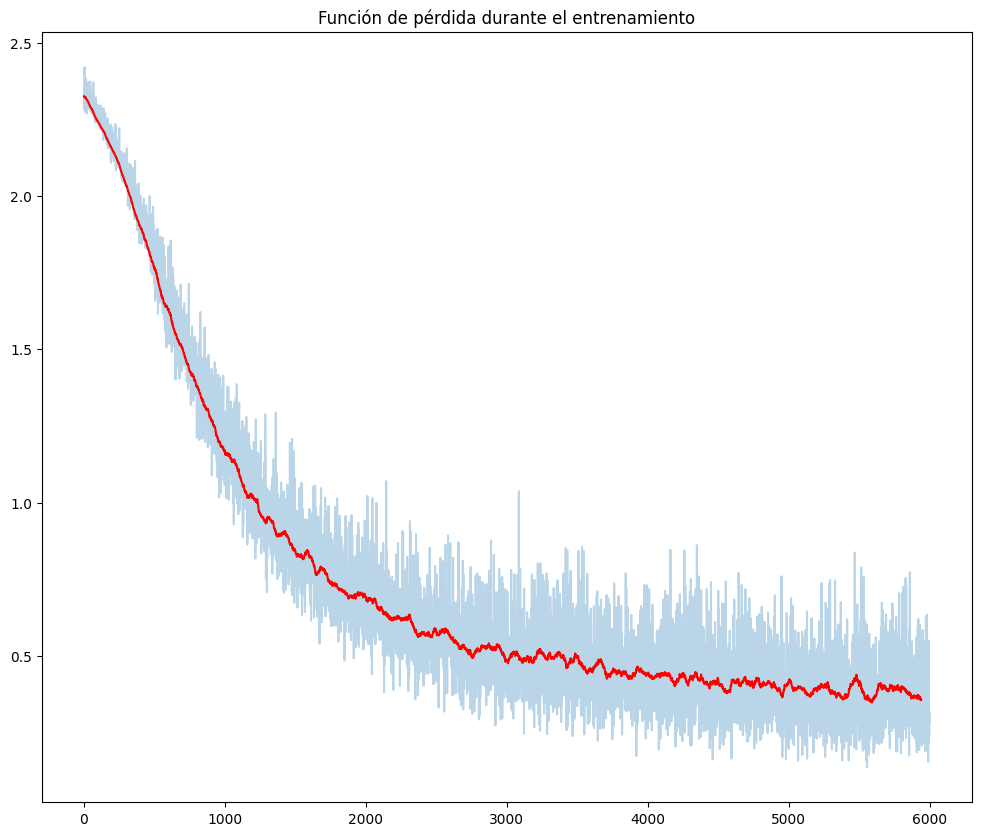

In [ ]:
# Definimos el modelo del perceptr√≥n
input_features = 28*28
hidden_neurons = 15
num_outputs = 10

# Tama√±o del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejectur√° el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetMLP(input_features, hidden_neurons, num_outputs)
net.to(device)

# Construimos el optimizador, y le indicamos que los par√°metros a optimizar
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos tambi√©n la funci√≥n de p√©rdida a utilizar
criterion = nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)

# N√∫mero de √©pocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la funci√≥n de p√©rdida en cada
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los par√°metros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la funci√≥n de p√©rdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la funci√≥n de p√©rdida cada 100 iteraciones
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la funci√≥n de p√©rdida
# y una versi√≥n suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Funci√≥n de p√©rdida durante el entrenamiento")


### Guardamos el modelo para poder reutilizarlo

In [ ]:
torch.save(net.state_dict(), "./mlp20.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los m√©todos `classification_report` y `confusion_matrix` de scikitlearn.

In [ ]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
input_features = 28*28
hidden_neurons = 15
num_outputs = 10
net = NetMLP(input_features,hidden_neurons,num_outputs)
net.load_state_dict(torch.load("./mlp20.pth"))
net.to(device)

<ipython-input-5-2a29e5d75892>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("./mlp20.pth"))


NetMLP(
  (hidden1): Linear(in_features=784, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.96      0.97      0.97      1135
           2       0.91      0.87      0.89      1032
           3       0.88      0.88      0.88      1010
           4       0.89      0.93      0.91       982
           5       0.84      0.82      0.83       892
           6       0.91      0.92      0.91       958
           7       0.92      0.88      0.90      1028
           8       0.85      0.84      0.85       974
           9       0.86      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.90      0.90      0.90     10000



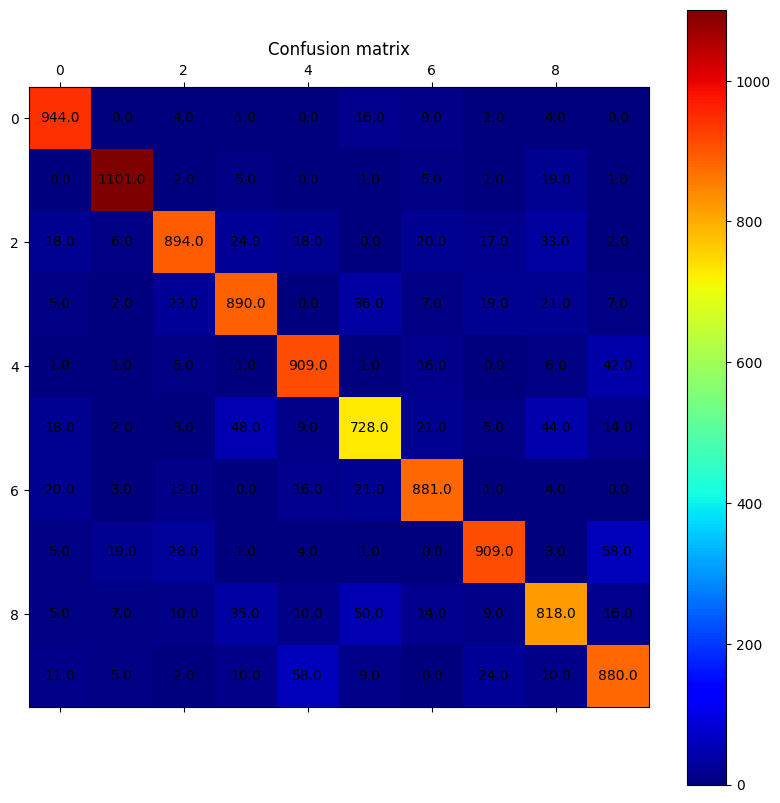

In [ ]:
def showTestResults(model):
  plt.rcParams['figure.figsize'] = [12, 10]
  from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

  # Genero un data loader para leer los datos de test
  loader_test = DataLoader(dataset=mnist_test, batch_size=10000, shuffle=False)
  x_test = list(loader_test)[0][0]
  y_test = list(loader_test)[0][1]

  # Muevo los tensores a la GPU
  x_test = x_test.to(device)

  # Realizo las predicciones del modelo
  pred = model(x_test)

  # Extraigo el √≠ndice de la predicci√≥n con mayor valor para decidir la clase asignada
  pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

  # Imprimo el reporte de clasificaci√≥n (accuracy, etc)
  print(classification_report(y_test, pred_y))

  # Computo la matriz de confusi√≥n y la muestro
  conf_mat = confusion_matrix(y_test, pred_y)
  plt.matshow(conf_mat, cmap='jet')

  for (i, j), z in np.ndenumerate(conf_mat):
      plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

  plt.title("Confusion matrix")
  plt.colorbar()

showTestResults(net)

In [ ]:
#Accuracy MLP:

from sklearn.metrics import accuracy_score

# Funci√≥n para evaluar accuracy en el conjunto de test
def evaluate_model(model, loader, device):
    model.eval()  # Poner el modelo en modo evaluaci√≥n
    y_true = []
    y_pred = []

    with torch.no_grad():  # Desactivar gradientes
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            pred = model(x)
            pred_classes = torch.argmax(pred, dim=1)  # Clase con mayor probabilidad

            y_true.extend(y.cpu().numpy())  # Convertir a numpy
            y_pred.extend(pred_classes.cpu().numpy())

    return accuracy_score(y_true, y_pred)

# Definir el DataLoader para test
loader_test = DataLoader(dataset=mnist_test, batch_size=1000, shuffle=False)

# Evaluar el Perceptr√≥n Multicapa (MLP)
accuracy_mlp = evaluate_model(net, loader_test, device)
print(f"üîπ Accuracy del MLP en test: {accuracy_mlp:.4f}")

# Si tambi√©n tienes el modelo CNN entrenado:
# accuracy_cnn = evaluate_model(net_cnn, loader_test, device)
# print(f"üîπ Accuracy de la CNN en test: {accuracy_cnn:.4f}")


üîπ Accuracy del MLP en test: 0.8954


# Red Neuronal Convolucional

Tambi√©n definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguir√° la siguiente estructura:
* Capa convolucional (`nn.Conv2D`) (6 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa convolucional (`nn.Conv2D`) (16 feature maps de salida) + ReLU
* Max pooling 2 x 2 (`F.max_pool2d`)
* Capa totalmente conectada (`nn.Linear`) (120 neuronas) + ReLU
* Capa totalmente conectada (`nn.Linear`) (84 neuronas) + ReLU
* Capa de salida (`nn.Linear`) (10 neuronas)

Notar que utilizaremos la funci√≥n `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tama√±o del filtro
* W: Tama√±o del feature map de entrada
* P: Padding
* S: Stride

El tama√±o de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [ ]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        #Primera capa convolucional: 6 feature maps, kernel 5x5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        #Segunda capa convolucional: 16 feature maps, kernel 5x5
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        #Capa totalmente conectada con 120 neuronas
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #Capa totalmente conectada con 84 neuronas
        self.fc2 = nn.Linear(120, 84)
        #Capa de salida con 10 neuronas (10 clases)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #Primera convoluci√≥n + ReLU + Max Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        #Segunda convoluci√≥n + ReLU + Max Pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        #Aplanar la salida para la capa totalmente conectada
        x = x.view(-1, 16 * 5 * 5)

        #Capas totalmente conectadas con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        #Capa de salida
        x = self.fc3(x)
        return x

Epoch 0, loss = 0.202442
Epoch 1, loss = 0.0979881
Epoch 2, loss = 0.212892
Epoch 3, loss = 0.027179
Epoch 4, loss = 0.0159332


Text(0.5, 1.0, 'Funci√≥n de p√©rdida durante el entrenamiento')

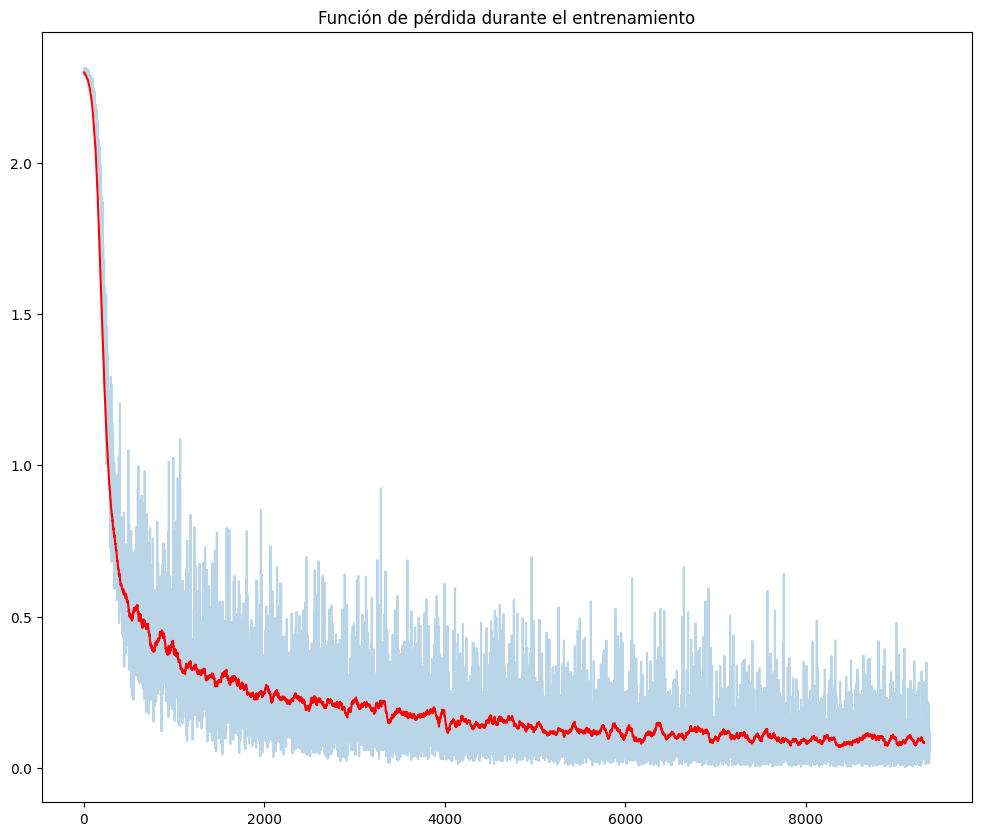

In [ ]:
# Tama√±o del batch de entrenamiento
batch_size = 50

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejectur√° el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetCNN()
net.to(device)

# Construimos el optimizador, y le indicamos que los par√°metros a optimizar
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos tambi√©n la funci√≥n de p√©rdida a utilizar
criterion = torch.nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)

# N√∫mero de √©pocas
num_epochs = 5

# Lista en la que iremos guardando el valor de la funci√≥n de p√©rdida en cada
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    # Itero sobre todos los batches del dataset
    for x, y in loader:
        # Seteo en cero los gradientes de los par√°metros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la funci√≥n de p√©rdida para luego graficarlo
        loss_list.append(loss.data.item())

    # Muestro el valor de la funci√≥n de p√©rdida cada 100 iteraciones
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la funci√≥n de p√©rdida
# y una versi√≥n suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Funci√≥n de p√©rdida durante el entrenamiento")


### Guardo el modelo

In [ ]:
torch.save(net.state_dict(), "./cnn20.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los m√©todos `classification_report` y `confusion_matrix` de scikitlearn.

In [ ]:
# Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
net = NetCNN()
net.load_state_dict(torch.load("./cnn20.pth"))
net.to(device)

<ipython-input-11-0cb86474e445>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("./cnn20.pth"))


NetCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.99      0.96      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.95      0.98      0.96       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



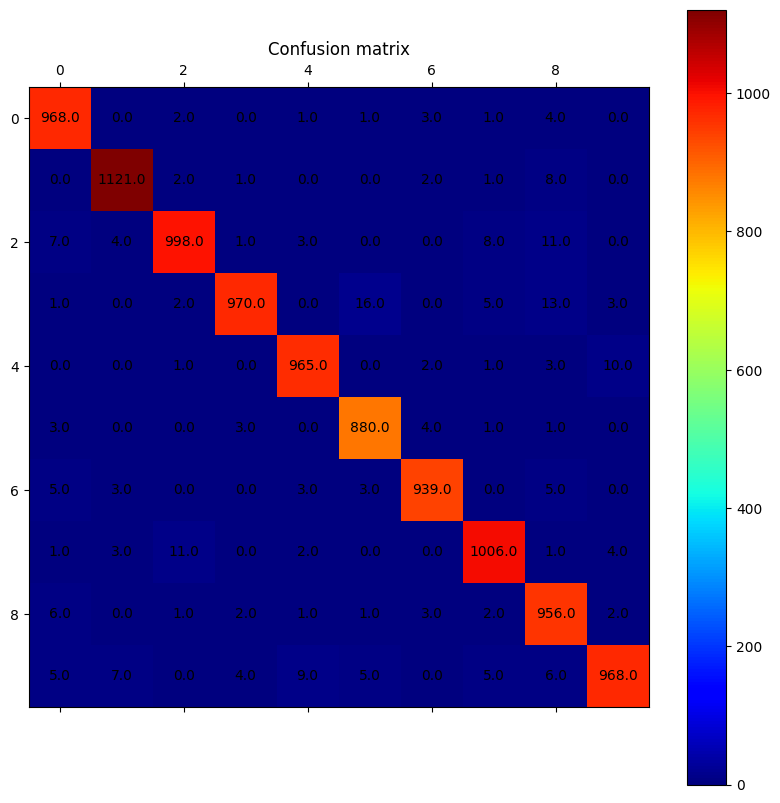

In [ ]:
# Mostramos los resultados
showTestResults(net)

In [ ]:
#Accuracy CNN

# Evaluar el modelo con la funci√≥n evaluate_model
accuracy_cnn = evaluate_model(net, loader_test, device)
print(f"üîπ Accuracy de la CNN en test: {accuracy_cnn:.4f}")


üîπ Accuracy de la CNN en test: 0.9771


# Entregable

1. Implementar el perceptr√≥n multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el c√°lculo del tama√±o de la entrada y salida en cada capa convolucional en funci√≥n de los par√°metros de cada capa (tama√±o del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tama√±o adecuado. Indicar el tama√±o de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida por el perceptr√≥n muticapa y la red neuronal convolucional.

## 1. Hecho en el c√≥digo

## 2. C√°lculo del tama√±o de salida en cada capa

Usamos la f√≥rmula:

$$
O = \frac{(W - F + 2P)}{S} + 1
$$  

para definir el tama√±o de salida en cada capa convolucional.

---

### **Primera capa convolucional**
Reemplazamos los siguientes valores en la f√≥rmula:

- \( W = 28 \) (tama√±o original de la imagen)
- \( F = 5 \) (tama√±o del kernel)
- \( P = 2 \) (padding aplicado)
- \( S = 1 \) (stride, desplazamiento del kernel)

Sustituyendo los valores:

$$
O = \frac{(28 - 5 + 2(2))}{1} + 1 = \frac{(28 - 5 + 4)}{1} + 1 = 28
$$

Por lo tanto, la salida despu√©s de `conv1` es **28 √ó 28 √ó 6**.

**Despu√©s de Max Pooling (2√ó2, stride=2):**  
Aplicamos la f√≥rmula del max pooling:

$$
O = \frac{(28 - 2)}{2} + 1 = 14
$$

Entonces, despu√©s de `pool1`, la salida es **14 √ó 14 √ó 6**.

---

### **Segunda capa convolucional**
Reemplazamos los siguientes valores en la f√≥rmula:

- \( W = 14 \) (tama√±o de entrada despu√©s de `pool1`)
- \( F = 5 \) (tama√±o del kernel)
- \( P = 0 \) (sin padding)
- \( S = 1 \) (stride, desplazamiento del kernel)

Sustituyendo los valores:

$$
O = \frac{(14 - 5 + 2(0))}{1} + 1 = \frac{(14 - 5)}{1} + 1 = 10
$$

Por lo tanto, la salida despu√©s de `conv2` es **10 √ó 10 √ó 16**.

**Despu√©s de Max Pooling (2√ó2, stride=2):**  
Aplicamos la f√≥rmula del max pooling:

$$
O = \frac{(10 - 2)}{2} + 1 = 5
$$

Entonces, despu√©s de `pool2`, la salida es **5 √ó 5 √ó 16**.

---

### **Capas totalmente conectadas**
Despu√©s de la segunda capa convolucional y su max pooling, **aplanamos** la salida:

$$
5 \times 5 \times 16 = 400
$$

Esta ser√° la entrada de la primera capa completamente conectada (`fc1`).

Luego, las capas totalmente conectadas transforman los datos de la siguiente manera:

- **`fc1`**: **400 ‚Üí 120**  
- **`fc2`**: **120 ‚Üí 84**  
- **`fc3`**: **84 ‚Üí 10** (donde 10 es el n√∫mero de clases en MNIST)

---

### **Tabla resumen:**
| Capa | Tama√±o de salida |
|------|-----------------|
| **Entrada** (imagen original) | 28 √ó 28 √ó 1 |
| **Conv1** (6 filtros, kernel 5√ó5, stride 1, padding 2) | 28 √ó 28 √ó 6 |
| **Max Pool1** (2√ó2, stride 2) | 14 √ó 14 √ó 6 |
| **Conv2** (16 filtros, kernel 5√ó5, stride 1, padding 0) | 10 √ó 10 √ó 16 |
| **Max Pool2** (2√ó2, stride 2) | 5 √ó 5 √ó 16 |
| **Flatten** (aplanar) | 400 |
| **FC1** | 120 |
| **FC2** | 84 |
| **FC3 (Salida - 10 clases)** | 10 |

---






## 3. Comparamos la accuracy de los dos modelos:

Accuracy MLP: 0.8954

Accuracy CNN: 0.9771

La CNN tiene 8% m√°s de accuracy que el MLP, lo cual es una mejora considerable, lo que confirma su superioridad para la clasificaci√≥n de im√°genes, ya que aprovecha patrones espaciales de las im√°genes.